# BAIT 509: Business Applications of Machine Learning
## Lecture 2 - Fundamentals of learning, train/test error

Tomas Beuzen, 8th January 2020

# Lecture outline
- [0. Recap (5 mins)](#0)
- [1. Lecture learning objectives](#1)
- [2. Train/Test error (30 mins)](#2)
- [3. ML error, and the "fundamental trade-off" (20 mins)](#3)
- [--- Break --- (10 mins)](#break)
- [4. Train/Validation/Test error and the Golden Rule (10 mins)](#4)
- [5. Class Exercise: (25 mins)](#5)
- [6. What we've learned today (5 mins)](#6)
- [7. Summary questions to ponder](#7)

# 0. Recap  (5 mins) <a id=0></a>

- What is machine learning (supervised/unsupervised, classification/regression)
- Machine learning terminology (observations, features, response)
- What is the decision tree algorithm and how does it work
- The scikit-learn library
- Parameters and hyperparameters

- We learned that we can develop and use a machine learning model in just a few lines of code!

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
df = pd.read_csv('data/cities_USA.csv',
                 index_col=0)  # load data
X = df.drop(columns='vote')  # the features
y = df[['vote']]  # the response
model = DecisionTreeClassifier(max_depth=3)  # initiate model framework
model.fit(X, y)  # fit the model
yp = model.predict(np.atleast_2d([-86, 39]))  # predict something
print(f"At lon = {-86} and lat = {39}, the model predicts: {yp[0]}")

At lon = -86 and lat = 39, the model predicts: blue


Some key questions...
1. How do we choose a value of `max_depth` (or other hyperparameters)?
2. Why not just use large `max_depth` for every supervised learning problem and get super high accuracy?
3. Is model performance on the training data a good indication of how it will perform on new data?

# 1. Lecture learning objectives  <a id=1></a>

- Identify the difference between training error and testing error
- Describe the concept of overfitting and the fundamental tradeoff
- Be able to split a dataset into train and test sets using the `train_test_split()` function
- Describe the golden rule and why it's important

# 2. Train/Test error (30 mins) <a id=2></a>
- We are going to explore the concept of error in ML models
- Last lecture we briefly touched on model accuracy/error
- Let's briefly revise the concept
- First, let's load in the required packages for this lecture notebook

In [2]:
import numpy as np
import altair as alt
import sys
sys.path.append('code/')
from model_plotting import plot_model

ModuleNotFoundError: No module named 'statsmodels'

- now let's load the cities data (from last lecture) again

In [2]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]

In [3]:
X

,lon,lat
1,-80.162475,25.692104
2,-80.214360,25.944083
3,-80.094133,26.234314
4,-80.248086,26.291902
5,-81.789963,26.348035
...,...,...
396,-97.460476,48.225094
397,-96.551116,48.591592
398,-166.519855,53.887114
399,-163.733617,67.665859


In [4]:
y

,vote
1,blue
2,blue
3,blue
4,blue
5,blue
...,...
396,red
397,blue
398,red
399,red


- here's a plot of the data using altair
- don't worry about this code too much, as you have not learned how to use altair and are not expected to know this

In [30]:
alt.Chart(df).mark_circle(size=100,
                                 opacity=1,
                                 stroke='black',
                                 strokeWidth=1
).encode(
    x=alt.X('lon', title='lon', scale=alt.Scale(domain=[-170, -60])),
    y=alt.Y('lat', title='lat', scale=alt.Scale(domain=[20, 70])),
    color=alt.Color('vote')
).properties(
    width=500,
    height=400
).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
    titleFontSize=20,
    labelFontSize=20
).interactive()

alt.Chart(...)

## 2.1 Training Error

### max_depth=1
- Let's first create a decision tree classifier with `max_depth=1`
- Recall that to create a model:
    - we first make an instance of the model class
    - we then `.fit()` the model with some data


In [6]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

- We can plot our model to visualise how it is classifying our data

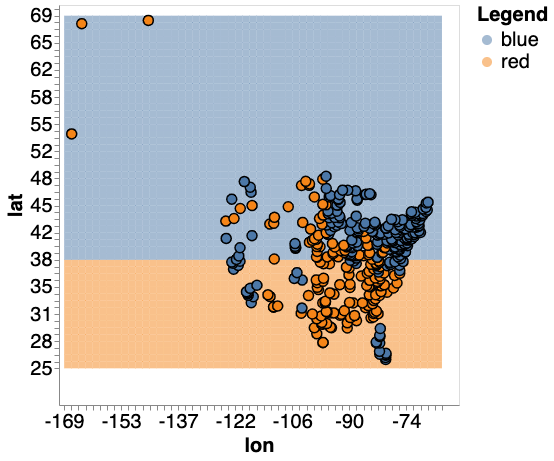

In [7]:
plot_model(X, y, model)

- For the case of `max_depth=1` we see that we have smoothed over much of the scatter in our data
- We have a very simple model!
- Recall that we can calculate the error of our model using the `.score()` method
- Previously we talked about accuracy, but typically we work in terms of error (1 - accuracy)

In [8]:
print(f"Error rate: {1 - model.score(X, y):.2f}")

Error rate: 0.25


- We get an error of 0.25
- Can we do better?

### max_depth=None
- Let's specify an unlimited `max_depth`
- I'll also now start chaining `.fit()` on a single line for succinctness

In [9]:
model = DecisionTreeClassifier(max_depth=None).fit(X, y)

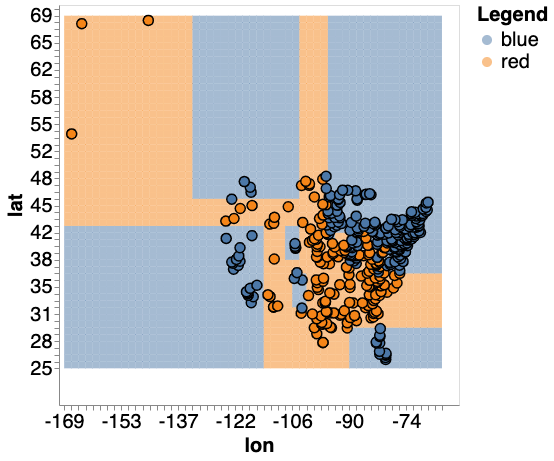

In [10]:
plot_model(X, y, model)

- We can see that with this model we are perfectly fitting every observation
- As a result, we except to have a 0 error rate...

In [11]:
print(f"Error rate: {1 - model.score(X, y):.2f}")

Error rate: 0.00


### How does error rate change vs. max_depth?

- Below is a plot of error versus max_depth
- For our decision tree model, we see that error decreases as we increase `max_depth`
- This is not unexpected, as we create a more complex tree (higher max_depth) we can fit all the peculiarities of our data to eventually get 0 error
- We will refer to this as "training error"

<img src='./img/max_depth_error.png' width="400"> 

## 2.2 Testing Error

#### Why not just use very large/unlimited `max_depth` for every supervised learning problem and get super high accuracy?
- Well, the goal of supervised learning is to predict unseen/new data...
- We can get 0 error on the training data using `max_depth=None`
- We perfectly classify every data point used to make the model

#### BUT, we want to know how our model performs on data not used in training!

- To do this, we usually split our dataset into parts
- We can use one part for "training" and one part for "testing"

In [12]:
X.shape

(400, 2)

- We see that our dataset contains 400 observations
- Let's use the first half of the data to train our model, and the second half to test it

In [13]:
# Use the first half as training data
X_train = X.iloc[:200]
y_train = y.iloc[:200]
# Use the second half as testing data
X_test = X.iloc[200:]
y_test = y.iloc[200:]

In [14]:
model = DecisionTreeClassifier(max_depth=None).fit(X_train, y_train)

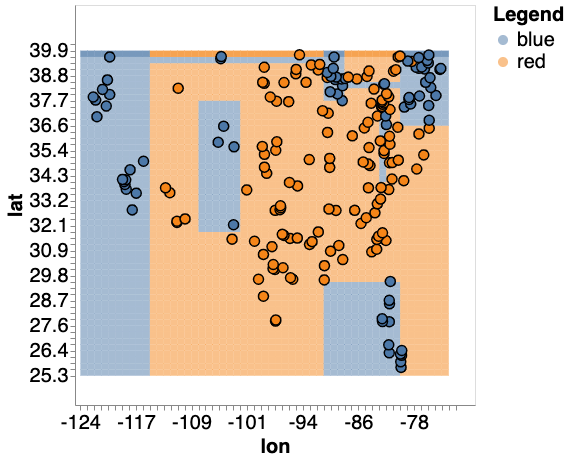

In [15]:
plot_model(X_train, y_train, model)

- Let's find our training error (error on the data used to train the model)
- As expected it is 0

In [16]:
print(f"Training error: {1 - model.score(X_train, y_train):.2f}")

Training error: 0.00


- But what about the test data?
- Let's plot the data (scatter points) along with our model (shaded region)
- We definitely see some misclassified points here!

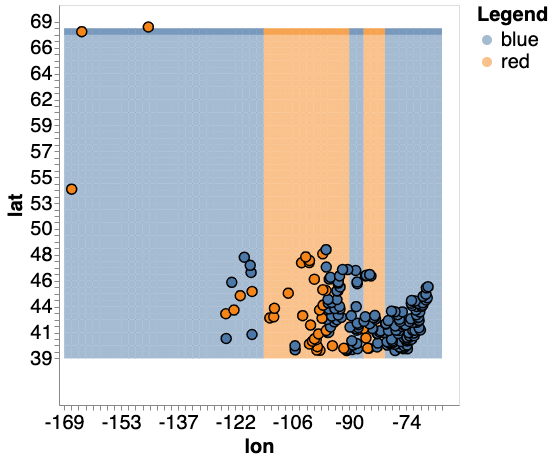

In [17]:
plot_model(X_test, y_test, model)

- We can already see that we aren't getting 0 error here
- Let's find out what the error actually is
- We will call this **testing error**

In [18]:
print(f"Testing error: {1 - model.score(X_test, y_test):.2f}")

Testing error: 0.30


- What is going on here???
- We have terrible accuracy on the test set!
- Maybe we didn't split our data very well...
- Maybe the first half of the data has some order to it that doesn't well represent the whole dataset...

In [19]:
X

,lon,lat
1,-80.162475,25.692104
2,-80.214360,25.944083
3,-80.094133,26.234314
4,-80.248086,26.291902
5,-81.789963,26.348035
...,...,...
396,-97.460476,48.225094
397,-96.551116,48.591592
398,-166.519855,53.887114
399,-163.733617,67.665859


- We do indeed see that our data is ordered by latitude!
- This means that we are training only on lower latitudes (the first 200 observations) and testing on higher latitudes (the last 200 observations)
- No wonder our model is not doing so well...
- Luckily, there's a solution
- The sklearn function `train_test_split()` is the most common function used to split data into train/test sets
- it shuffles the data first, then splits it
- It can be imported as follows

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# shuffles and then splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

- Let's remake our model on this new training data and print the training error and testing error

In [22]:
model = DecisionTreeClassifier(max_depth=None).fit(X_train, y_train)
print(f"Training error: {1 - model.score(X_train, y_train):.2f}")
print(f"Testing error: {1 - model.score(X_test, y_test):.2f}")

Training error: 0.00
Testing error: 0.11


- Ah, we are doing much better than before!
- But still the errors are not the same
- The testing error seems to be different to the training error
- The punch line:
### the error rate on our training data may NOT be a good indicator of error rate on new data

# -------- Break (10 mins) -------- <a id="break"></a>

# 3. ML error, and the "fundamental trade-off" (20 mins) <a id=3></a>

## Error

- Error is composed of two quantities: **irreducible error** and **reducible error**

### Irreducible error
- Recall that we are trying to model `Y` which is a random variable, i.e., $Y=f(X)+\epsilon$
- We use ML to help us determine the function $f(X)$
- $\epsilon$ is the random error term
- This is measurement error that cannot be reduced no matter how good our model is
- For example, say we are interested in modelling the height of human beings
- Let's say this quantity is normally distributed with mean=165, sd=30:

<img src='./img/height.png' width="400"> 

- If we pick a random person in the world, we are uncertain about what their height is (according to the above distribution)
- But the whole point of prediction is that we can use features (`X`) to become more certain!
- For example, if we know the person's gender is female we can narrow our distribution to the blue distribution (because females are on average shorter than males):

<img src='./img/height_female.png' width="400"> 

- If we know a person's sex is female and their weight is 65kg, we can narrow our distribution further to the red distribution (because weight and height are generally correlated):

<img src='./img/height_female_65.png' width="400"> 

- But the point here is that we can never be exactly certain of `Y` no matter what, there is always uncertainty!
- (these are random variables after all, if they weren't random, we wouldn't need machine learning to predict them!)
- We simply cannot account for all the things that influence a person's height
- So what’s one to do?
- Well we try to make the most certain predictions we can (to minimise uncertainty)

### Reducible error
- As the name suggests, this is the error that we can reduce
- It is related to the model we are using to make predictions
- (this is in contrast to irreducible error which is related to the data)
- We decompose reducible error into **bias** and **variance**
- Bias = difference between model predictions and the true value (think of it as the error rate we've been calculating)
- Variance = variability of model predictions (think of it as the difference in error rate between train and test sets)
- So how does this relate to our train vs test error problem?

## Underfitting/Overfitting
- **Underfitting** = when a model is too simple and not well fit to the patterns in the data (high bias, low variance)
    - e.g., A decision tree with `max_depth=1`
- **Overfitting** = when a model fits too closely to the peculiarities in the training data (low bias, high variance)
    - e.g., A decision tree with `max_depth=None`
- There is usually (always?) a tradeoff between bias and variance
- It’s referred to as the "fundamental trade-off"/"bias-variance tradeoff"
- Here's the typical picture:
    - Bias initially reduces as models become more complex
    - However as models become even more complex, variance increases
    - The best models have low bias and low variance

<img src='./img/tradeoff.png' width="500">

[Source: dziganto.github.io](https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/) 

- How about for our data?
- The test error of decision tree models typically does not increase over time
- Why?

<img src='./img/max_depth_error_train_test.png' width="600"> 

## Finding the "optimal model"
- So to find the optimal model, we split our data into train and test sets, find the error for different `max_depth` values (or any other hyperparameters) and pick the best one?
- EASY!
- Using the above plot for reference, we see that picking a max_depth > 10 will generally give us the lowest error, great!
- But is there something wrong with this approach to selecting hyperparameter values?

# 4. Train/Validation/Test error and the Golden Rule (10 mins) <a id=4></a>

## The Golden Rule
- The approach above is WRONG!
- The problem is that we are using our test data to help us create a good model
- This optimistically biases our model! (i.e., we find a an error lower than would be expected when we deploy the model)
- In simple terms, we used the test data to pick a `max_depth` value, so our test error is biased
- This violates the **Golden Rule** of ML: YOU CANNOT USE THE TEST DATA TO BUILD YOUR MODEL

- How can we avoid violating the **Golden Rule**?
- **With another dataset! A validation dataset!**
- We usually use 3 datasets to create, optimise and test a ML model (read more [here](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7))
    - Training set: used to learn the model
    - Validation set: used to optimize the model (e.g., choose the best hyperparameters)
    - Testing set: used to test the model (lock it in a "vault" until you're ready to test)
- e.g.:

<img src='./img/split.png' width="550">

## True/False Questions
1. The fundamental tradeoff/bias-variance tradeoff of ML states that as training error goes down, testing error goes up.
2. More "complicated" models (e.g., deep trees) are more likely to overfit than "simple" ones (e.g., decision stumps).
3. If we had an infinite amount of training data, overfitting would not be a problem.
4. If our training error is extremely low, that means we're overfitting.

# 5. Class Exercise: developing our first ML model (25 mins) <a id=5></a>

The workflow described below is really the fundamental approach to developing machine learning models: there is typically three stages - training, optimization, and testing.

Your tasks:

1. Split the cities dataset into 3 parts using `train_test_split()`: 40% training, 40% validation, 20% testing
2. How many observations are in each data set?
3. Using only the training set, fit 3 different decision tree classifiers (each with a different `max_depth`)
4. Obtain the error of each classifier on the validation data. Which model does the best? Are their big differences between your models?
5. Using the `max_depth` that gave you the lowest error, fit a new model using both the training and validation sets (80% of your original data)
6. Use this model to predict the test data. Is the error on the test data the same as the validation data? Is your result surprising?

In [4]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns='vote')
y = df[['vote']]
# 1
X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                  y_trainval,
                                                  test_size=0.5,
                                                  random_state=123)
# 2
print(f"There are {X_train.shape[0]} observations in the training set.")
print(f"There are {X_val.shape[0]} observations in the validation set.")
print(f"There are {X_test.shape[0]} observations in the testing set.")
# 3/4
for max_depth in [1, 5, 10, 15, 20]:
    model = DecisionTreeClassifier(max_depth=max_depth).fit(X_train, y_train)
    print(f"For max_depth={max_depth}, validation error = {1 - model.score(X_val, y_val):.2f}.")
# 5/6
model = DecisionTreeClassifier(max_depth=10).fit(X_trainval, y_trainval)
print(f"Optimum model has test error = {1 - model.score(X_test, y_test):.2f}.")
# We get a lower error here than the validation error. This is not necessarily surprising
# because we used significantly more data to build our model before testing. More on this
# next lecture!

There are 160 observations in the training set.
There are 160 observations in the validation set.
There are 80 observations in the testing set.
For max_depth=1, validation error = 0.29.
For max_depth=5, validation error = 0.19.
For max_depth=10, validation error = 0.19.
For max_depth=15, validation error = 0.18.
For max_depth=20, validation error = 0.21.
Optimum model has test error = 0.11.


# 6. What we've learned today (5 mins) <a id="6"></a>

- Training/testing error
- Irreducible/reducible error and the bias/variance tradeoff
- Train/validation/test datasets and fundamental ML model development

# 7. Questions to ponder <a id="7"></a>

1. How do we split our data into train/validation/test sets?
2. What if our dataset is small? Can we still split it up?
3. If we don't want to/need to optimize hyperparameters, do we still need a validation set?
4. We've only discussed one algorithm so far, what about other ML algorithms, do they behave like decision trees?